<a href="https://colab.research.google.com/github/tsurikow/hse-ml/blob/main/Tsurikow_AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [ ]:
df.sample(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1280,2023,EN,FT,Data Analyst,48000,USD,48000,US,0,US,M
2979,2022,SE,FT,Data Scientist,120000,USD,120000,US,100,US,M
2667,2022,SE,FT,Data Engineer,160395,USD,160395,US,100,US,M
3636,2021,MI,FT,Data Engineer,93150,USD,93150,US,0,US,M
50,2023,SE,FT,Data Scientist,275300,USD,275300,US,100,US,M


In [ ]:
params = {'experience_level': ['SE', 'MI', 'EN', 'EX'],
'employment_type': ['FT', 'PT', 'CT', 'FL'],
'remote_ratio': [0, 50, 100],
'company_size': ['S', 'M', 'L']}

for key, value in params.items():
    elements = df[key].value_counts(dropna=False)
    element_list = elements.index.tolist()
    print("❕",set(value))
    print("❔",set(element_list))
    intersection_set = set(value).intersection(set(element_list))

    if len(intersection_set)==len(element_list):
        print(f"✅'{key}' does not contain excess elements")
    else:
        print(f"❌'{key}' contains excess elements")
        print(set(element_list)-set(value))
    print('')

❕ {'EX', 'SE', 'MI', 'EN'}
❔ {'EX', 'SE', 'MI', 'EN'}
✅'experience_level' does not contain excess elements

❕ {'PT', 'CT', 'FT', 'FL'}
❔ {'PT', 'CT', 'FT', 'FL'}
✅'employment_type' does not contain excess elements

❕ {0, 50, 100}
❔ {0, 50, 100}
✅'remote_ratio' does not contain excess elements

❕ {'S', 'L', 'M'}
❔ {'M', 'L', 'S'}
✅'company_size' does not contain excess elements



## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [ ]:
df.shape

(3755, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [ ]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


In [ ]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [ ]:
df.duplicated().sum()

1171

In [ ]:
df[df.duplicated()]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
115,2023,SE,FT,Data Scientist,150000,USD,150000,US,0,US,M
123,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
153,2023,MI,FT,Data Engineer,100000,USD,100000,US,100,US,M
154,2023,MI,FT,Data Engineer,70000,USD,70000,US,100,US,M
160,2023,SE,FT,Data Engineer,115000,USD,115000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
3439,2022,MI,FT,Data Scientist,78000,USD,78000,US,100,US,M
3440,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
3441,2022,SE,FT,Data Engineer,115000,USD,115000,US,100,US,M
3586,2021,MI,FT,Data Engineer,200000,USD,200000,US,100,US,L


In [ ]:
df.nunique()

,0
work_year,4
experience_level,4
employment_type,4
job_title,93
salary,815
salary_currency,20
salary_in_usd,1035
employee_residence,78
remote_ratio,3
company_location,72


In [ ]:
numeric_cols = df.select_dtypes(include=['number'])

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).sum()

print(outliers)

work_year         76
salary           113
salary_in_usd     63
remote_ratio       0
dtype: int64


In [ ]:
(df == 0).sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,1923
company_location,0


In [ ]:
df.select_dtypes(include=['number']).corr()

,work_year,salary,salary_in_usd,remote_ratio
work_year,1.000000,-0.094724,0.228290,-0.236430
salary,-0.094724,1.000000,-0.023676,0.028731
salary_in_usd,0.228290,-0.023676,1.000000,-0.064171
remote_ratio,-0.236430,0.028731,-0.064171,1.000000




```
После базовых проверок обнаружены дубликаты, удаляем их
```



In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(2584, 11)

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [ ]:
location_similarity = (df['employee_residence'] == df['company_location']).mean() * 100
print(location_similarity)

96.28482972136223




```
Регион проживания сотрудника в 96% случаев совпадает с местоположением компании.
Одну из этих колонок можно удалить
Правильнее будет удалить колонку employee_residence,
поскольку company_location более стабильный признак
и напрямую связан с экономической зоной.
```



In [ ]:
df.nunique()

,0
work_year,4
experience_level,4
employment_type,4
job_title,93
salary,815
salary_currency,20
salary_in_usd,1035
employee_residence,78
remote_ratio,3
company_location,72


**Salary и salary_currency не соответсвуют постановке задачи, поскольку эти переменные являются частью целевой переменной, и они не должны быть нам известны заранее на этапе прогнозирования. Данные об экономической зоне включены в company_location, и как мы уже выяснили employee_residence совпадает в 96% случаев. Так что эти колонки удаляются.**

**Много категорий в `job_title`, `employee_residence` и `company_location`**

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
# удаляем колонки приговоренные к удалению в предыдущем пункте
y = df['salary_in_usd']
X = df.drop(columns=['salary_in_usd', 'employee_residence', 'salary', 'salary_currency' ])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.sample(5)

,work_year,experience_level,employment_type,job_title,remote_ratio,company_location,company_size
3692,2021,MI,FT,Data Engineer,50,GB,S
2786,2022,EN,FT,Data Scientist,50,IN,M
378,2023,SE,FT,Machine Learning Engineer,0,US,M
579,2023,MI,FT,Data Scientist,0,GB,M
1415,2023,EN,FT,Data Engineer,0,US,M


## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [ ]:
# remote_ratio заявлен как категориальный признак, но там может быть заложена линейная зависимость
X_train_num = X_train[['work_year', 'remote_ratio']]
X_test_num = X_test[['work_year', 'remote_ratio']]


## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
import numpy as np

lr_num = LinearRegression()
lr_num.fit(X_train_num, y_train)

y_pred_num = lr_num.predict(X_test_num)

mape_num = mean_absolute_percentage_error(y_test, y_pred_num)
rmse_num = root_mean_squared_error(y_test, y_pred_num)

print(f"MAPE: {mape_num:.4f}")
print(f"RMSE: {rmse_num:.2f}")

MAPE: 0.8291
RMSE: 64000.53


Плохое качество модели, мало признаков и зависимостей. MAPE сильно выше 0.5

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(random_state=42)
xgboost.fit(X_train_num, y_train)

y_pred_num = xgboost.predict(X_test_num)

mape_num = mean_absolute_percentage_error(y_test, y_pred_num)
rmse_num = root_mean_squared_error(y_test, y_pred_num)

print(f"Test MAPE: {mape_num:.4f}")
print(f"Test RMSE: {rmse_num:.2f}")

Test MAPE: 0.7708
Test RMSE: 62433.35


Качество модели в целом такое же, ошибка немного уменьшилась

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
#!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

cat = ['experience_level', 'employment_type', 'job_title',
            'company_location', 'company_size', 'remote_ratio']
num = ['work_year']

def evaluate_model(name, y_true, y_pred):
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    rmse_value = root_mean_squared_error(y_true, y_pred)
    print(f"{name} 🚀 MAPE: {mape_value:.4f}, RMSE: {rmse_value:.2f}")

In [ ]:
#!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

ct_ohe = ColumnTransformer(
    transformers=[
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore'),
            cat
        )
    ],
    remainder='passthrough'
)

pipe_cat_ohe = Pipeline([
    ('encoder', ct_ohe),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])
pipe_cat_ohe.fit(X_train, y_train)
y_pred_cat_ohe = pipe_cat_ohe.predict(X_test)
evaluate_model("CatBoost + OHE", y_test, y_pred_cat_ohe)

pipe_lr_ohe = Pipeline([
    ('encoder', ct_ohe),
    ('model', LinearRegression())
])
pipe_lr_ohe.fit(X_train, y_train)
y_pred_lr_ohe = pipe_lr_ohe.predict(X_test)
evaluate_model("LinearReg + OHE", y_test, y_pred_lr_ohe)

CatBoost + OHE 🚀 MAPE: 0.4561, RMSE: 52840.80
LinearReg + OHE 🚀 MAPE: 0.4613, RMSE: 52786.68


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ct_ord = ColumnTransformer(
    transformers=[
        (
            'ord',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            cat
        )
    ],
    remainder='passthrough'
)

pipe_cat_ord = Pipeline([
    ('encoder', ct_ord),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])
pipe_cat_ord.fit(X_train, y_train)
y_pred_cat_ord = pipe_cat_ord.predict(X_test)
evaluate_model("CatBoost + OrdinalEnc", y_test, y_pred_cat_ord)

pipe_lr_ord = Pipeline([
    ('encoder', ct_ord),
    ('model', LinearRegression())
])
pipe_lr_ord.fit(X_train, y_train)
y_pred_lr_ord = pipe_lr_ord.predict(X_test)
evaluate_model("LinearReg + OrdinalEnc", y_test, y_pred_lr_ord)

CatBoost + OrdinalEnc 🚀 MAPE: 0.5960, RMSE: 57284.45
LinearReg + OrdinalEnc 🚀 MAPE: 0.5906, RMSE: 56690.86


In [ ]:
from sklearn.preprocessing import TargetEncoder

ct_target = ColumnTransformer(
    transformers=[
        (
            'target',
            TargetEncoder(target_type="continuous", random_state=42),
            cat
        )
    ],
    remainder='passthrough'
)

pipe_cat_target = Pipeline([
    ('encoder', ct_target),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])
pipe_cat_target.fit(X_train, y_train)
y_pred_cat_target = pipe_cat_target.predict(X_test)
evaluate_model("CatBoost + TargetEnc", y_test, y_pred_cat_target)

pipe_lr_target = Pipeline([
    ('encoder', ct_target),
    ('model', LinearRegression())
])
pipe_lr_target.fit(X_train, y_train)
y_pred_lr_target = pipe_lr_target.predict(X_test)
evaluate_model("LinearReg + TargetEnc", y_test, y_pred_lr_target)

CatBoost + TargetEnc 🚀 MAPE: 0.4804, RMSE: 52831.24
LinearReg + TargetEnc 🚀 MAPE: 0.4628, RMSE: 51294.02


**При использовании закодированных категориальных признаков качество модели значительно улучшилось. Лучший результат по MAPE показал CatBoost + OHE, худший результат показал CatBoost + OrdinalEnc.**
**Линейная регрессия лучше себя показывает с TargetEncoder и OrdinalEncoder, но хуже себя показывает по отношению к бустингу при применении OHE. Тем не менее лучший показатель RMSE именно и линейной регрессии с TargetEncoder**


**Вместо LabelEncoder использовался OrdinalEncoder, потому что LabelEncoder проблематично применять на признаках, а не на целевой переменной. В признаках так же содерджатся категории, которые есть в тренировочной выборке, но отсутствуют в тестовой, что тоже усложняет применение LabelEncoder, не предназначенного для этого.**

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
errors_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_cat_ohe
}, index=X_test.index)

errors_df['abs_error'] = np.abs(errors_df['y_true'] - errors_df['y_pred'])

errors_df = pd.concat([errors_df, X_test], axis=1)

top20_errors = errors_df.sort_values('abs_error', ascending=False).head(20)
top20_errors

,y_true,y_pred,abs_error,work_year,experience_level,employment_type,job_title,remote_ratio,company_location,company_size
2011,430967,63839.672109,367127.327891,2022,MI,FT,Data Analyst,0,GB,M
1288,385000,130642.144455,254357.855545,2023,SE,FT,Data Analyst,0,US,M
3517,68428,229439.606145,161011.606145,2020,SE,FT,Data Scientist,100,US,L
2406,315000,158828.906134,156171.093866,2022,SE,FT,Data Engineer,100,US,M
1695,72000,224461.595854,152461.595854,2023,SE,FT,Applied Scientist,0,US,L
3485,38400,180072.628743,141672.628743,2021,MI,FT,Applied Machine Learning Scientist,100,US,M
1145,272000,134145.729323,137854.270677,2023,SE,FT,Machine Learning Software Engineer,0,US,M
3519,230000,97629.952274,132370.047726,2021,EX,FT,Head of Data,50,RU,L
1847,260000,130697.893712,129302.106288,2022,MI,FT,Data Engineer,0,US,M
1647,291500,165424.017281,126075.982719,2023,SE,FT,Data Engineer,0,US,M


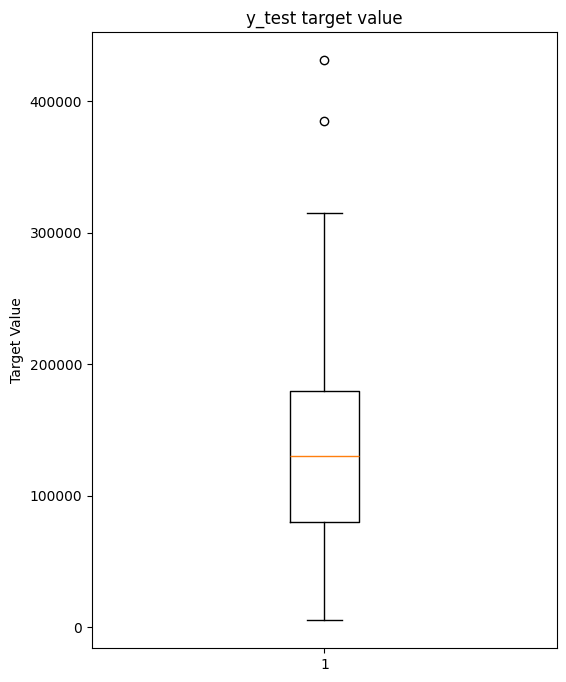

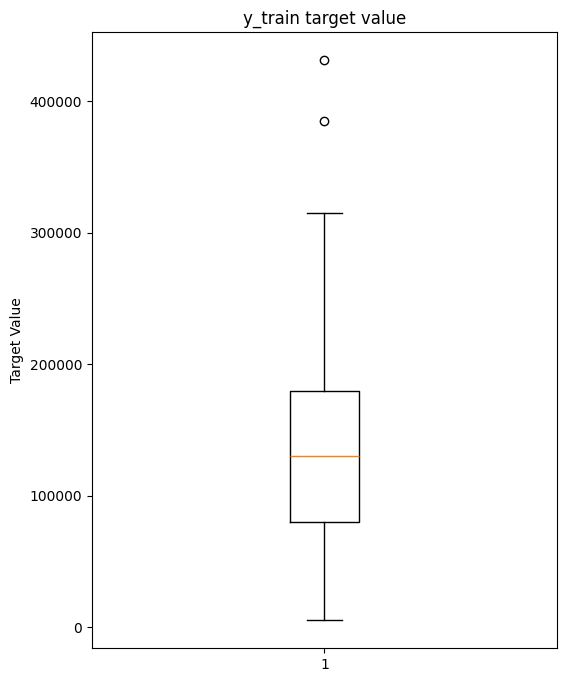

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 8))
plt.boxplot(y_test)
plt.title("y_test target value")
plt.ylabel("Target Value")
plt.show()

plt.figure(figsize=(6, 8))
plt.boxplot(y_test)
plt.title("y_train target value")
plt.ylabel("Target Value")
plt.show()

**Мы наблюдаем самые большие ошибки за пределами Q1-Q3. Две самые большие ошибки находятся за пределами межквартильного размаха + Q3. Скорее всего нам нужно больше данных в этих областях, чтобы более точно в них предсказывать. Так же в данных могут быть ошибки, например, кажется странным, что аналитик данных с опытом MI получает 430 тысяч долларов в британской компании средних размеров. Возможно, есть ошибка в зарплате или опыте.**

**Также, глядя на данные в целом, можно предположить, что разбивка Job title на категории по отдельным ключевым словам может дать дополнительные зависимости**

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
pd.DataFrame(df['job_title'].value_counts())

,count
job_title,
Data Engineer,598
Data Scientist,538
Data Analyst,396
Machine Learning Engineer,206
Analytics Engineer,91
...,...
Compliance Data Analyst,1
Deep Learning Researcher,1
Staff Data Analyst,1


In [ ]:
# попробуем найти дополнительные зависимости в job_title

def simplify_job_title(title):
    t = title.lower()
    if "applied" in t:
        return "applied"
    elif "data engineer" in t:
        return "data engineer"
    elif "data analyst" in t:
        return "data analyst"
    elif "machine learning" in t:
        return "machine learning"
    elif "analytics engineer" in t:
        return "analytics engineer"
    elif "ai" in t:
        return "ai"
    elif "head" in t:
        return "head"
    elif "director" in t:
        return "director"
    elif "manager" in t:
        return "manager"
    elif "engineer" in t:
        return "engineer"
    elif "analyst" in t:
        return "analyst"
    elif "architect" in t:
        return "architect"
    else:
        return "other"

df["job_title_simplified"] = df["job_title"].apply(simplify_job_title)

y = df['salary_in_usd']
X = df.drop(columns=['salary_in_usd', 'employee_residence', 'salary', 'salary_currency' ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat = ['experience_level', 'employment_type', 'job_title', 'job_title_simplified',
            'company_location', 'company_size', 'remote_ratio']

In [ ]:
X_train.sample(5)

,work_year,experience_level,employment_type,job_title,remote_ratio,company_location,company_size,job_title_simplified
3243,2022,MI,FT,Data Engineer,0,GB,M,data engineer
236,2023,SE,FT,Data Engineer,0,US,M,data engineer
146,2023,SE,FT,Machine Learning Engineer,100,US,M,machine learning
2570,2022,SE,FT,Marketing Data Analyst,100,GB,S,data analyst
2015,2022,SE,FT,Data Analyst,0,US,M,data analyst


In [ ]:
ct_ohe = ColumnTransformer(
    transformers=[
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore'),
            cat
        )
    ],
    remainder='passthrough'
)

pipe_cat_ohe = Pipeline([
    ('encoder', ct_ohe),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])
pipe_cat_ohe.fit(X_train, y_train)
y_pred_cat_ohe = pipe_cat_ohe.predict(X_test)
evaluate_model("CatBoost + OHE", y_test, y_pred_cat_ohe)

CatBoost + OHE 🚀 MAPE: 0.4490, RMSE: 52827.75


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Удалось немного снизить MAPE путем добавления нового признака, состоящего из ключевых слов из job_title**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'model__depth': [8, 10],
    'model__learning_rate': [0.02, 0.05, 0.8],
    'model__n_estimators': [100, 200, 300],
    'model__l2_leaf_reg': [1, 2, 3]
}


mape_scorer = make_scorer(
    mean_absolute_percentage_error,
    greater_is_better=False
)

gs_cat = GridSearchCV(
    estimator=pipe_cat_ohe,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=3,
    n_jobs=-1
)

gs_cat.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['experience_level',
                                                                          'employment_type',
                                                                          'job_title',
                                                                          'job_title_simplified',
                                                                          'company_location',
                                                                          'company_size',
                                                                          'remote_ratio'])])),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x7dd1bd066990>)]),
             n_jobs=-1,
             param_grid={'model__depth': [8, 10],
                         'model__l2_leaf_reg': [1, 2, 3],
                         'model__learning_rate': [0.02, 0.05, 0.8],
                         'model__n_estimators': [100, 200, 300]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'))

In [ ]:
print("Best MAPE:", -gs_cat.best_score_)
print("Best hyperparameters:", gs_cat.best_params_)

best_pipe_cat = gs_cat.best_estimator_

Best MAPE: 0.42519866564311926
Best hyperparameters: {'model__depth': 8, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.05, 'model__n_estimators': 300}


In [ ]:
%%time
best_pipe_cat.fit(X_train, y_train)

CPU times: user 2.1 s, sys: 341 ms, total: 2.45 s
Wall time: 2.54 s


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'job_title_simplified',
                                                   'company_location',
                                                   'company_size',
                                                   'remote_ratio'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7dd1bcf5d5d0>)])

In [ ]:
%%time
y_pred_cat_best = best_pipe_cat.predict(X_test)

CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 45.4 ms


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
evaluate_model("CatBoost + OHE + BestParams", y_test, y_pred_cat_best)

CatBoost + OHE + BestParams 🚀 MAPE: 0.4611, RMSE: 52204.40


## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
param_grid = {
    'model__max_depth': [8, 10],
    'model__learning_rate': [0.02, 0.05, 0.8],
    'model__n_estimators': [100, 200, 300],
    #'model__subsample': [0.8, 1.0],
    #'model__colsample_bytree': [0.8, 1.0]
}

pipe_xgb_ohe = Pipeline([
    ('encoder', ct_ohe),
    ('model', XGBRegressor(random_state=42, verbosity=0))
])

gs_xgb = GridSearchCV(
    estimator=pipe_xgb_ohe,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=3,
    n_jobs=-1
)

gs_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['experience_level',
                                                                          'employment_type',
                                                                          'job_title',
                                                                          'job_title_simplified',
                                                                          'company_location',
                                                                          'company_size',
                                                                          'remote_ratio'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     ca...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.02, 0.05, 0.8],
                         'model__max_depth': [8, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'))

In [ ]:
print("Best MAPE:", -gs_xgb.best_score_)
print("Best hyperparameters:", gs_xgb.best_params_)

best_pipe_xgb = gs_xgb.best_estimator_

Best MAPE: 0.4082027077674866
Best hyperparameters: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 300}


In [ ]:
%%time
best_pipe_xgb.fit(X_train, y_train)

CPU times: user 1.54 s, sys: 9.61 ms, total: 1.55 s
Wall time: 1.22 s


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'job_title_simplified',
                                                   'company_location',
                                                   'company_size',
                                                   'remote_ratio'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylev...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
%%time
y_pred_xgb_best = best_pipe_xgb.predict(X_test)

CPU times: user 55.7 ms, sys: 583 µs, total: 56.3 ms
Wall time: 78.6 ms


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
evaluate_model("XGBoost + OHE + BestParams", y_test, y_pred_xgb_best)

XGBoost + OHE + BestParams 🚀 MAPE: 0.4322, RMSE: 54015.89


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
from lightgbm import LGBMRegressor

param_grid = {
    'model__max_depth': [5, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300]
}

pipe_lgbm_ohe = Pipeline([
    ('encoder', ct_ohe),
    ('model', LGBMRegressor(random_state=42))
])

gs_lgbm = GridSearchCV(
    estimator=pipe_lgbm_ohe,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=3,
    n_jobs=-1
)

gs_lgbm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 38
[LightGBM] [Info] Start training from score 133570.320271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['experience_level',
                                                                          'employment_type',
                                                                          'job_title',
                                                                          'job_title_simplified',
                                                                          'company_location',
                                                                          'company_size',
                                                                          'remote_ratio'])])),
                                       ('model',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [5, 8, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False, response_method='predict'))

In [ ]:
print("Best MAPE:", -gs_lgbm.best_score_)
print("Best hyperparameters:", gs_lgbm.best_params_)

best_pipe_lgbm = gs_lgbm.best_estimator_

Best MAPE: 0.4215945834049182
Best hyperparameters: {'model__learning_rate': 0.05, 'model__max_depth': 8, 'model__n_estimators': 200}


In [ ]:
%%time
best_pipe_lgbm.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 38
[LightGBM] [Info] Start training from score 133570.320271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'job_title',
                                                   'job_title_simplified',
                                                   'company_location',
                                                   'company_size',
                                                   'remote_ratio'])])),
                ('model',
                 LGBMRegressor(learning_rate=0.05, max_depth=8,
                               n_estimators=200, random_state=42))])

In [ ]:
%%time
y_pred_lgbm_best = best_pipe_lgbm.predict(X_test)

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 28.5 ms


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
evaluate_model("LGBM + OHE + BestParams", y_test, y_pred_lgbm_best)

LGBM + OHE + BestParams 🚀 MAPE: 0.4543, RMSE: 53215.34


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

**XGBoost + OHE с подобранными параметрами `{'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 300}` показала наилучший результат по MAPE `MAPE: 0.4322` `RMSE: 54015.89`**
**По RMSE лучший результат показала модель CatBoost + OHE `MAPE: 0.4611, RMSE: 52204.40` с параметрами `{'model__depth': 8, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.05, 'model__n_estimators': 300}`**

**CatBoost и XGBoost обучаются и предсказывают дольше LGBM, но в данном конкретном случае все три модели работают быстро. В зависимости от важности метрики можно выбрать как XGBoost, так и CatBoost**

**Бустингами удалось добиться лучшего скора по MAPE, но по RMSE лучший скор остался за линейной регрессией с TargetEncoder и параметрами по умолчанию**\
**Вывод: применение бустингов в данном случае целесообразно, если мы хотим добиться лучшего MAPE**

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
X_test_data = pd.read_csv("samsung_test.txt", delim_whitespace=True, header=None)
X_train_data = pd.read_csv("samsung_train.txt", delim_whitespace=True, header=None)
y_test_data = pd.read_csv("samsung_test_labels.txt", delim_whitespace=True, header=None)
y_train_data = pd.read_csv("samsung_train_labels.txt", delim_whitespace=True, header=None)

<ipython-input-360-4c354b170bad>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_data = pd.read_csv("samsung_test.txt", delim_whitespace=True, header=None)
<ipython-input-360-4c354b170bad>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_data = pd.read_csv("samsung_train.txt", delim_whitespace=True, header=None)
<ipython-input-360-4c354b170bad>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test_data = pd.read_csv("samsung_test_labels.txt", delim_whitespace=True, header=None)
<ipython-input-360-4c354b170bad>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train_data = pd.read_cs

In [ ]:
X_test_data.shape

(2947, 561)

In [ ]:
y_test_data.shape

(2947, 1)

In [ ]:
X = pd.concat([X_train_data, X_test_data], axis=0, ignore_index=True)
y = pd.concat([y_train_data, y_test_data], axis=0, ignore_index=True)

In [ ]:
X.shape

(10299, 561)

In [ ]:
y.shape

(10299, 1)

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled.shape

(10299, 561)

In [ ]:
y.shape

(10299, 1)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
print("N components: ", pca.n_components_)
print("Explained variance ratio: ", pca.explained_variance_ratio_.sum())

N components:  65
Explained variance ratio:  0.9004833346822928


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

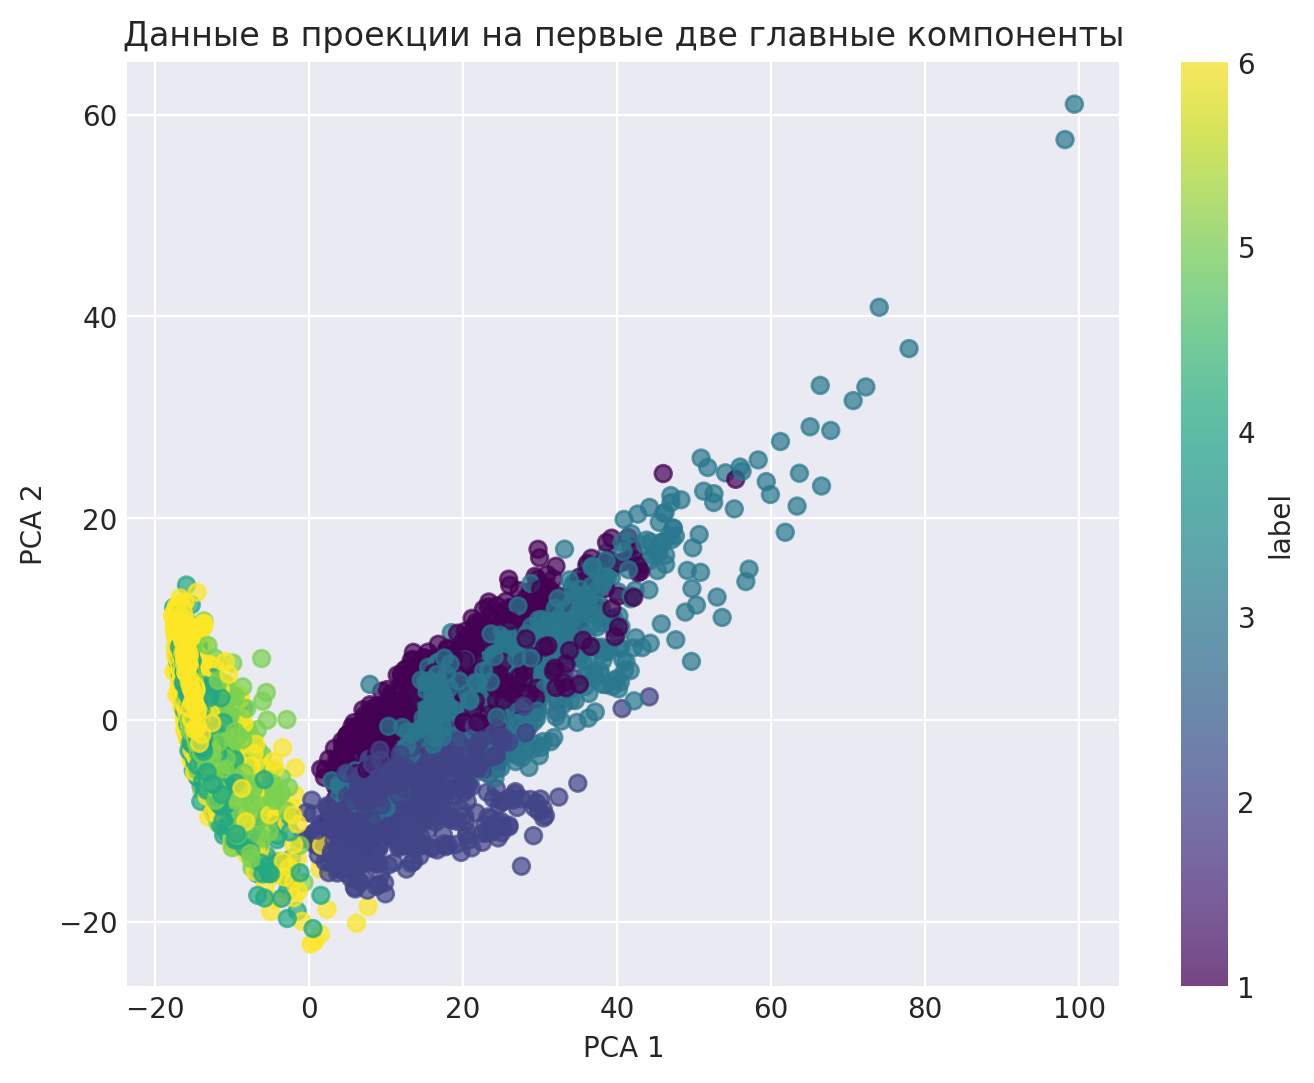

In [ ]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_2[:, 0],
    X_pca_2[:, 1],
    c=y,
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="label")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Данные в проекции на первые две главные компоненты")
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=6,
    n_init=100,
    random_state=RANDOM_STATE
)


In [ ]:
%%time
kmeans.fit(X_pca)

CPU times: user 11.5 s, sys: 7.05 s, total: 18.6 s
Wall time: 12.6 s


KMeans(n_clusters=6, n_init=100, random_state=42)

In [ ]:
%%time
cluster_labels = kmeans.predict(X_pca)

CPU times: user 4.84 ms, sys: 980 µs, total: 5.82 ms
Wall time: 6.72 ms


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

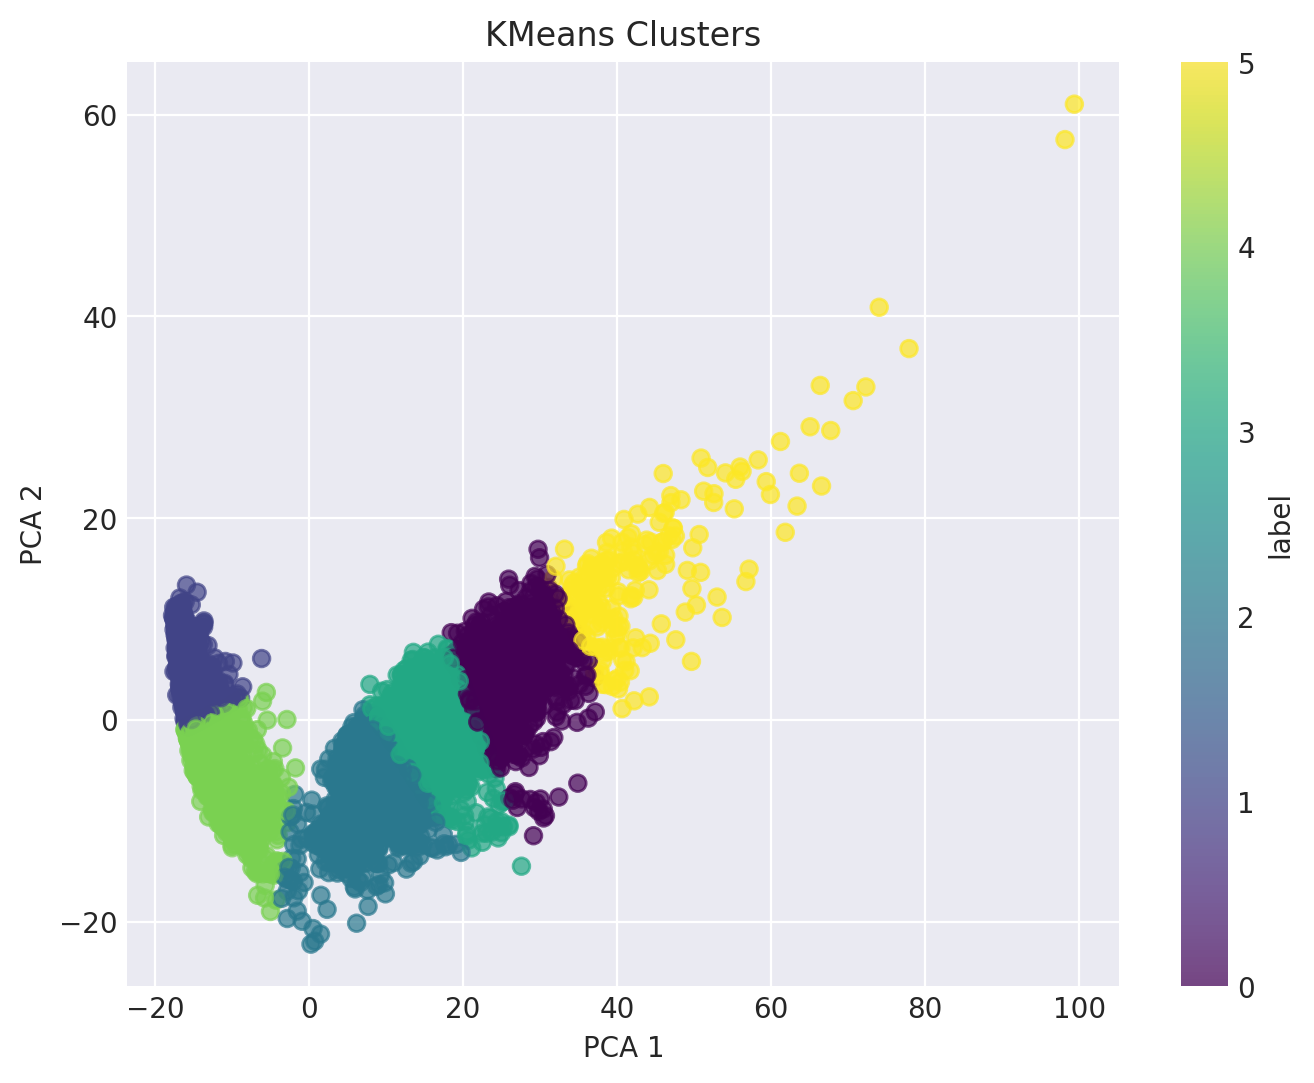

In [ ]:
kmeans.fit(X_pca_2)

labels = kmeans.predict(X_pca_2)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_2[:, 0],
    X_pca_2[:, 1],
    c=labels,
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="label")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters")
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
from sklearn.metrics import adjusted_rand_score, v_measure_score

y_true = y.squeeze()
ari = adjusted_rand_score(y_true, cluster_labels)
v_measure = v_measure_score(y_true, cluster_labels)


print(f"Adjusted Rand Index: {ari:.4f}")
print(f"V-measure: {v_measure:.4f}")

Adjusted Rand Index: 0.4195
V-measure: 0.5600


* ARI близок к 1, если модель идеально повторила разбиение
* V‐measure ближе к 1 при хорошем соответствии кластеров классам
* В данном случае метрики говорят о средне-низком качестве кластеризации, поскольку только одна из метрик превышает 0.5

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering(
    n_clusters=6,
    linkage='ward'

)

In [ ]:
%%time
clust_labels = clust.fit_predict(X_pca_2)

CPU times: user 5.01 s, sys: 577 ms, total: 5.58 s
Wall time: 5.57 s


In [ ]:
%%time
labels = clust.labels_

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


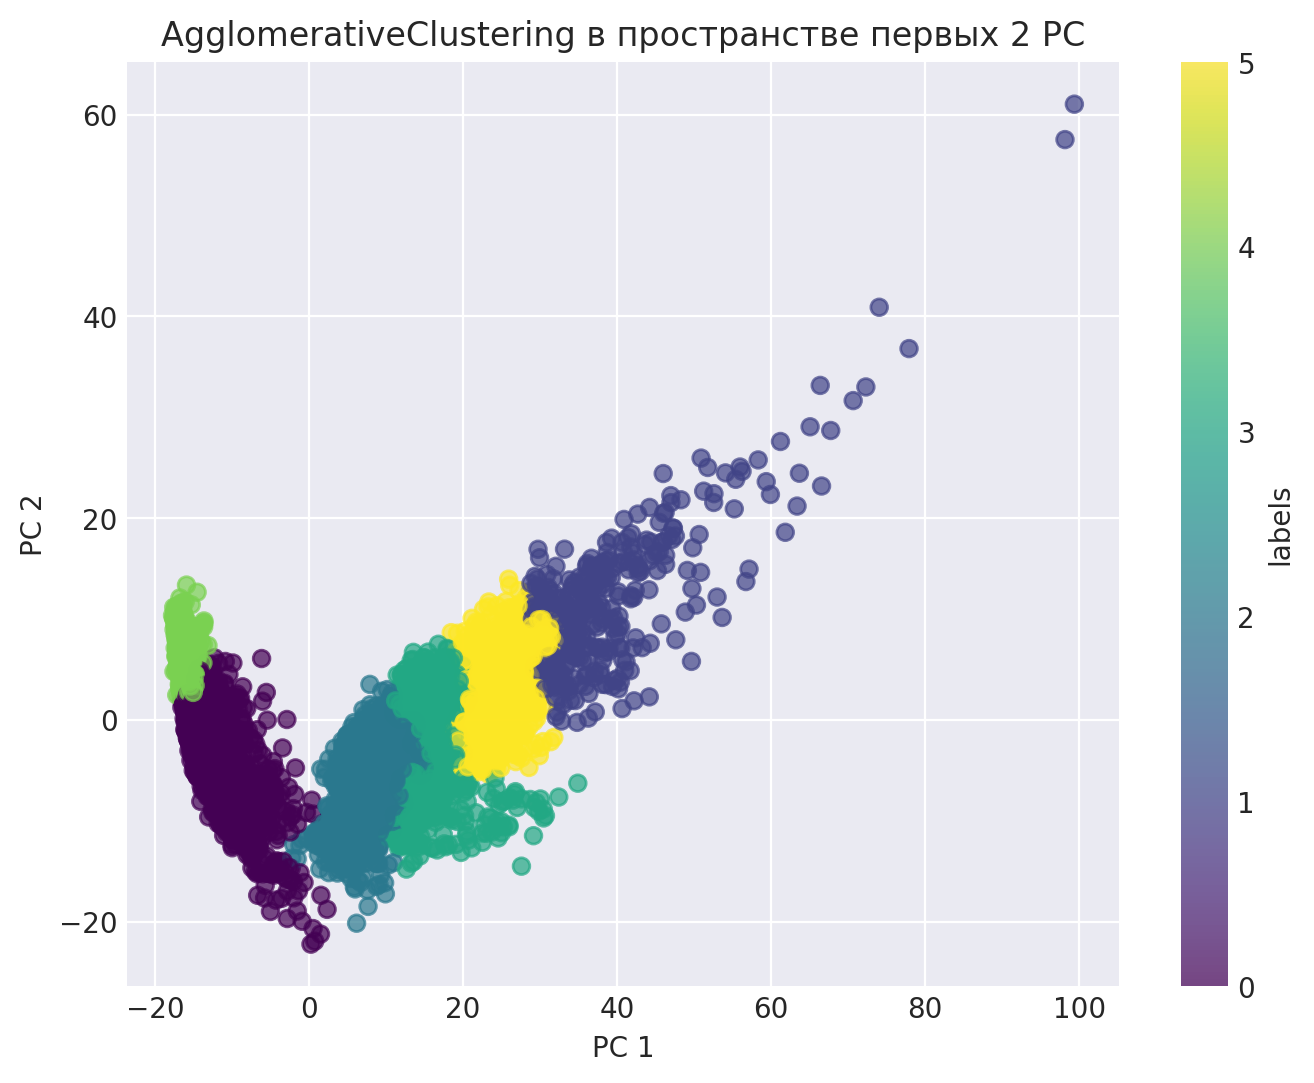

Adjusted Rand Index: 0.2626
V-measure: 0.4339


In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca_2[:, 0],
    X_pca_2[:, 1],
    c=clust_labels,
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="labels")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("AgglomerativeClustering в пространстве первых 2 PC")
plt.show()

y_true = y.squeeze()
ari = adjusted_rand_score(y_true, labels)
v_measure = v_measure_score(y_true, labels)


print(f"Adjusted Rand Index: {ari:.4f}")
print(f"V-measure: {v_measure:.4f}")

**Метрикине изменились сильно, существенное ухудшение по сравнению с KMeans, можно сделать вывод, что иерархический метод ХУЖЕ соответствует особенностям датасета**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

In [ ]:
df_clusters = pd.DataFrame(X_scaled).copy()
df_clusters['cluster'] = cluster_labels
df_clusters['true_label'] = y_true

cluster_means = df_clusters.groupby('cluster').mean()
cluster_means

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,true_label
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.012458,0.009569,0.007495,-0.849106,-0.934936,-0.908371,-0.841558,-0.934453,-0.914172,-0.849094,...,-0.274359,-0.250157,-0.020498,0.018032,0.047770,-0.012811,1.907363,-1.757852,-1.505744,5.890644
1,0.119140,-0.010608,-0.000121,1.305137,1.218675,1.060435,1.311916,1.193223,1.042274,1.293111,...,0.326540,0.282730,-0.092544,0.022961,0.047829,-0.061873,-0.479377,0.549799,0.474576,2.077882
2,0.044228,0.026172,0.013565,-0.877118,-0.921589,-0.892816,-0.871497,-0.920876,-0.897161,-0.868091,...,-0.404879,-0.336017,0.003080,0.003356,-0.046209,0.030848,-0.454075,0.196683,0.182296,4.550912
3,-0.093525,-0.111087,-0.089618,0.707577,0.809471,0.826535,0.691874,0.830407,0.851651,0.719102,...,0.141289,0.136007,0.079404,-0.035667,-0.056670,0.035547,-0.421719,0.557165,0.493245,1.772562
4,-0.114506,0.169954,0.155281,-0.756718,-0.626033,-0.559787,-0.755237,-0.617644,-0.545460,-0.776770,...,0.370485,0.302142,0.043611,0.035888,0.005816,0.015725,0.111552,-0.154602,-0.237132,4.905576
5,0.067151,-0.065572,-0.126212,1.655453,1.645764,1.839497,1.643035,1.586034,1.748563,1.647835,...,0.146571,0.032843,-0.182767,-0.153668,0.297797,-0.178939,-0.462663,0.530564,0.662205,2.422939


In [ ]:
df_clusters.groupby(['cluster','true_label']).size()

cluster  true_label
0        4               90
         6             1556
1        1              740
         2              296
         3              890
2        4             1235
         5             1344
         6               53
3        1              904
         2             1241
         3              320
         4                1
         6                5
4        2                2
         4              451
         5              562
         6              330
5        1               78
         2                5
         3              196
dtype: int64

**Некоторые классы похожи на определенный тип активности, некоторые сильно смешаны. В кластерах 1, 2, 3 и 4 смешаны несколько типов активности. Кластер 0 практически однозначно определяется как активность 6. Возможно сама природа активностей дает неоднозначные и смешанные данные, не всегда позволяющие точно определить вид активности. Нет ясного описания данных, возможно они взяты за промежуток времени, в котором могло быть несколько активностей**/
**Кластеризация получилась не очень качественная, метрики достаточно слабые, много смешанных классов, но в то же время кластеры довольно сильно отличаются друг от друга**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

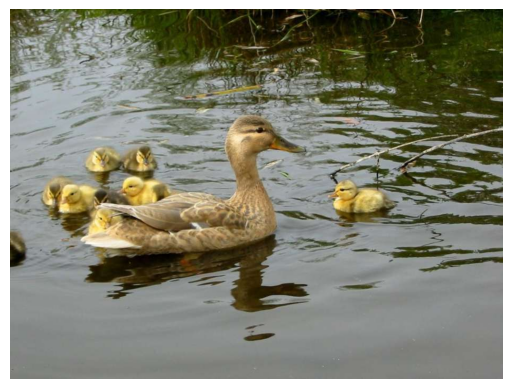

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
duck = Image.open("duck.jpg")

plt.imshow(duck)
plt.axis("off")
plt.show()

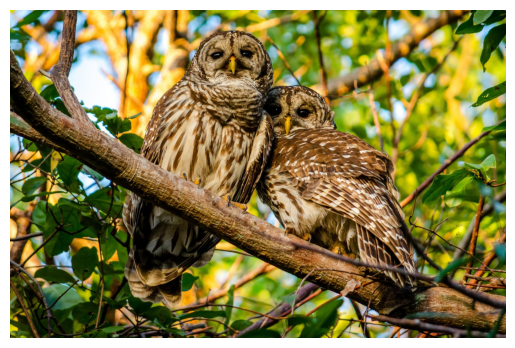

In [19]:
owls = Image.open("Owls.jpg")

plt.imshow(owls)
plt.axis("off")
plt.show()

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [13]:
import numpy as np
from sklearn.cluster import KMeans


def find_components(image, lmbd, n_clusters):
    H, W, _ = image.shape
    yy, xx = np.indices((H, W))

    img_flat = image.reshape(-1, 3).astype(np.float32)
    xx_flat = (lmbd * xx.flatten()).astype(np.float32)
    yy_flat = (lmbd * yy.flatten()).astype(np.float32)

    features = np.column_stack([xx_flat, yy_flat, img_flat[:, 0], img_flat[:, 1], img_flat[:, 2]])

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(features)
    labels = kmeans.labels_

    label_map = labels.reshape(H, W)
    segmented_img = np.zeros_like(image, dtype=np.uint8)

    for c in range(n_clusters):
        mask = (label_map == c)
        mean_color = image[mask].mean(axis=0)
        segmented_img[mask] = mean_color.astype(np.uint8)

    return label_map, segmented_img

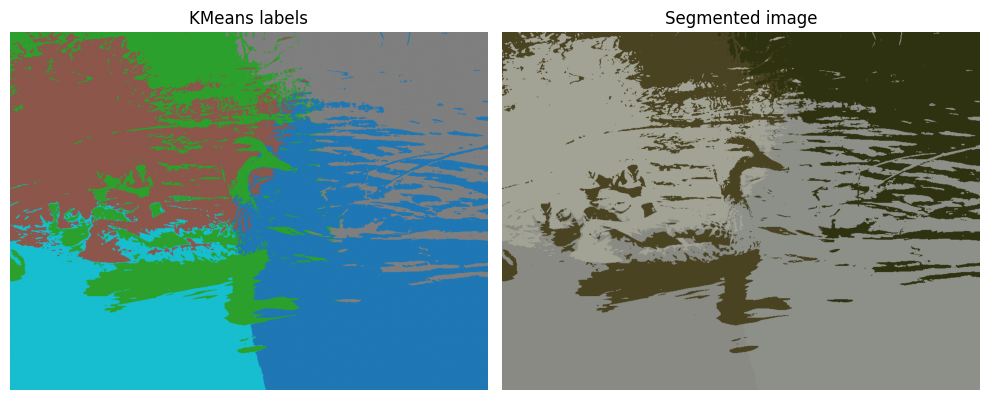

In [16]:
lambda_value = 0.3
n_clusters = 5
duck_array = np.array(duck)

label_map, seg_duck = find_components(duck_array, lambda_value, n_clusters)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(label_map, cmap="tab10")
plt.title("KMeans labels")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_duck)
plt.title("Segmented image")
plt.axis("off")

plt.tight_layout()
plt.show()

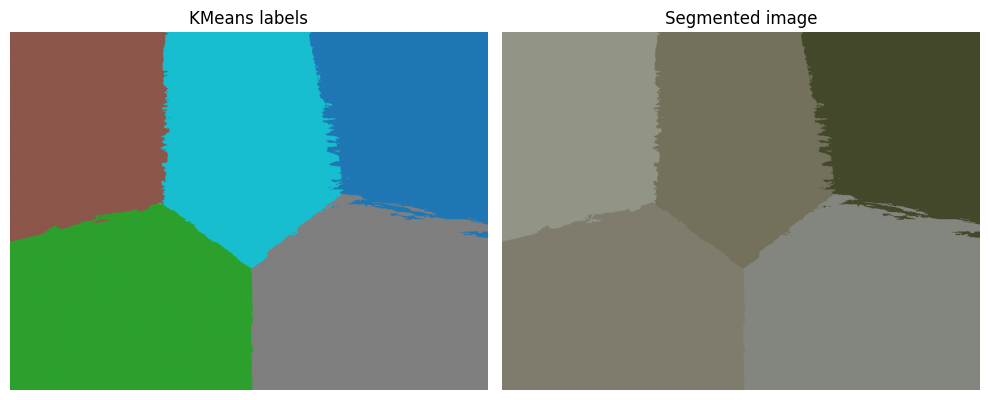

In [23]:
lambda_value = 1.5
n_clusters = 5
duck_array = np.array(duck)

label_map, seg_duck = find_components(duck_array, lambda_value, n_clusters)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(label_map, cmap="tab10")
plt.title("KMeans labels")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_duck)
plt.title("Segmented image")
plt.axis("off")

plt.tight_layout()
plt.show()

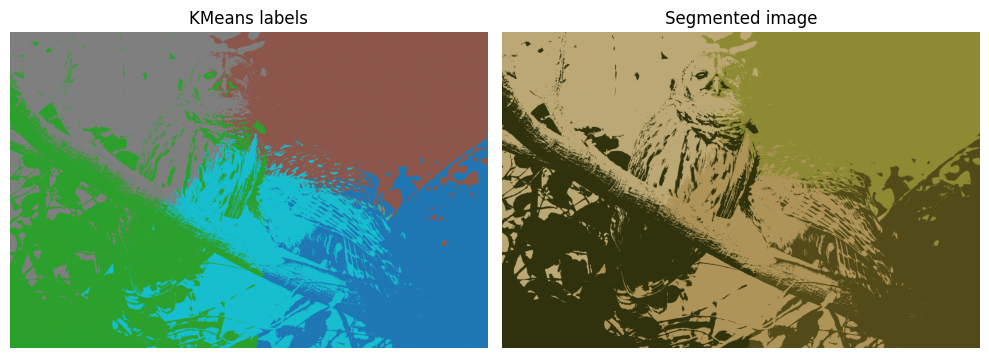

In [20]:
lambda_value = 0.3
n_clusters = 5
owls_array = np.array(owls)

label_map, seg_owls = find_components(owls_array, lambda_value, n_clusters)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(label_map, cmap="tab10")
plt.title("KMeans labels")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_owls)
plt.title("Segmented image")
plt.axis("off")

plt.tight_layout()
plt.show()

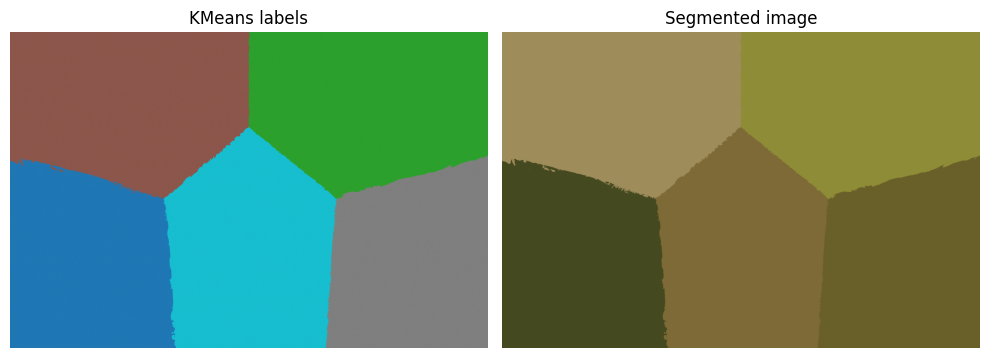

In [21]:
lambda_value = 1.5
n_clusters = 5
owls_array = np.array(owls)

label_map, seg_owls = find_components(owls_array, lambda_value, n_clusters)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(label_map, cmap="tab10")
plt.title("KMeans labels")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_owls)
plt.title("Segmented image")
plt.axis("off")

plt.tight_layout()
plt.show()

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

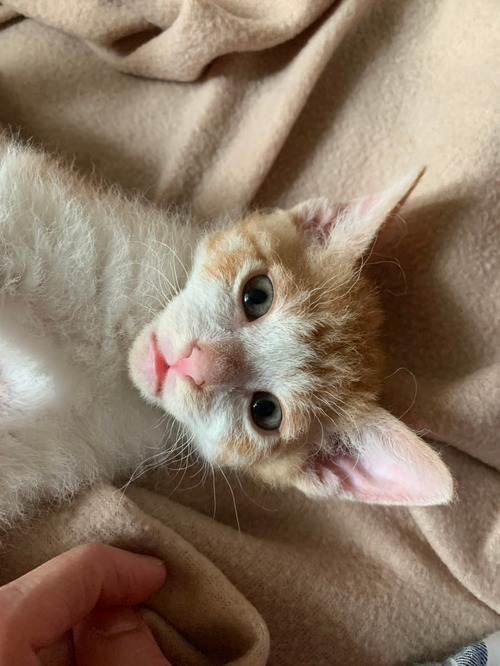